# Age Determination of Buyers

## Project Description:
The "Bread-Salt" network supermarket is implementing a computer vision system for processing photographs of customers. Photo fixation in the checkout area will help determine the age of customers in order to:

- Analyze purchases and recommend products that may interest customers of that age group.
- Monitor the integrity of cashiers when selling alcohol.

We will build a model that, based on a photograph, approximates the age of a person. We have a set of photos of people with their specified ages at our disposal.

Project Execution:

1. Conduct an exploratory analysis of the photo dataset.
2. Prepare the data for training.
3. Train the neural network and evaluate its quality.

## Exploratory Data Analysis:

Import all the necessary libraries.

In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's load the data.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train = ImageDataGenerator(rescale=1./255)
train_flow = train.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

image, age = next(train_flow)

print(f'Обучающая выборка: {image.shape}')
print(f'Целевая выборка: {age.shape}')

Found 7591 validated image filenames.
Обучающая выборка: (32, 224, 224, 3)
Целевая выборка: (32,)


In [3]:
display(labels.head(10))
display(labels.tail(10))
display(labels.describe())
labels.info()
display(f'Дубликаты: {labels.duplicated().sum()}')
display(f'Пропущенные значения:')
display(labels.isna().sum())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


,file_name,real_age
7581,007603.jpg,29
7582,007604.jpg,24
7583,007605.jpg,5
7584,007606.jpg,27
7585,007607.jpg,10
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


'Дубликаты: 0'

'Пропущенные значения:'

file_name    0
real_age     0
dtype: int64

The data is qualitative, without missing values or duplicates.

Let's plot the distribution of ages in the dataset.

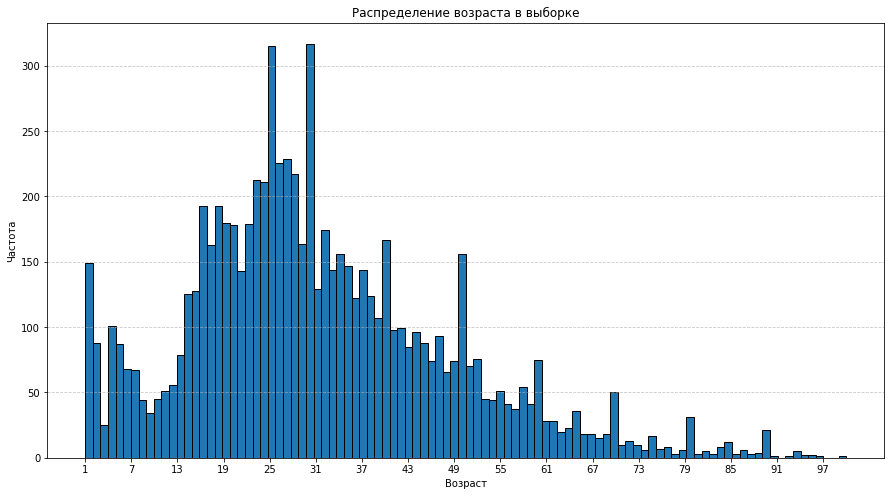

In [4]:
plt.figure(figsize=(15, 8))
plt.hist(labels['real_age'], bins=100, edgecolor='k')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')
plt.grid(axis='y', linestyle='--', alpha=0.7)

age_ticks = np.arange(min(labels['real_age']), max(labels['real_age'])+1, 6)
plt.xticks(age_ticks)

plt.show()

Judging by the graph, the dataset is most well-represented for people aged 13 to 49. There are fewer people of advanced age, suggesting that the model may perform less well for individuals older than 60. Outliers at 1 year, 25, 30, 40, and other milestone ages may indicate that the labeling was not very accurate, and ages were averaged. However, considering the total number of people is 7591, these outliers may not have a critically significant impact on the future model training.

Let's display 15 photos on the screen.

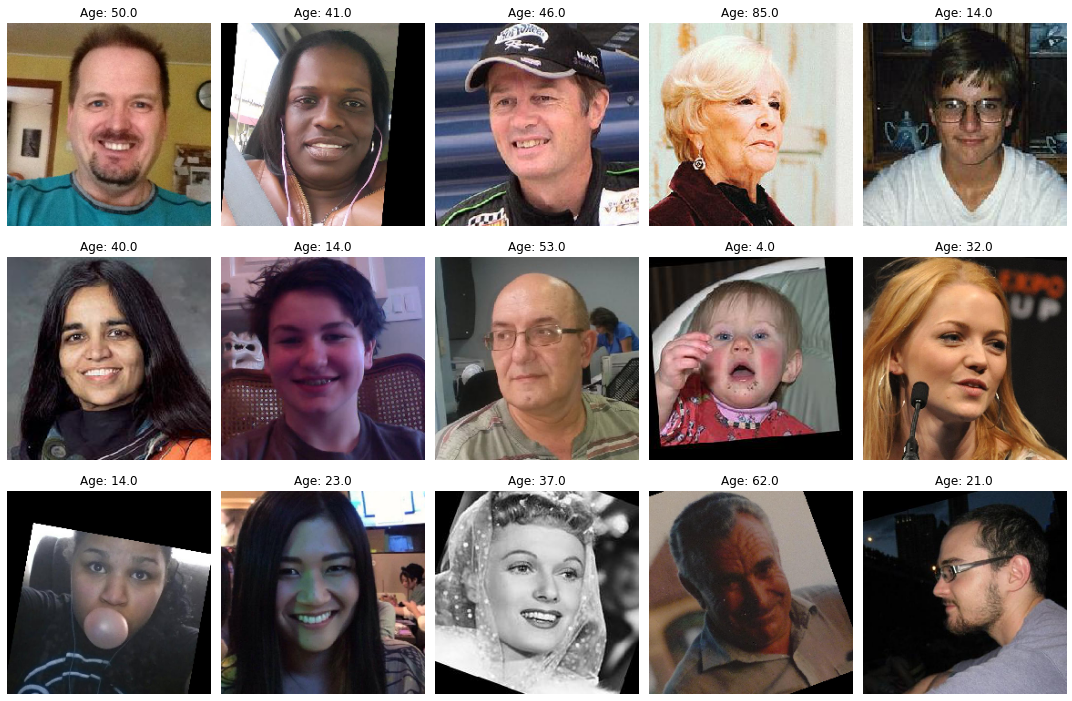

In [5]:
num_images_to_display = 15

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.ravel()

for i in range(num_images_to_display):
    axes[i].imshow(image[i])
    axes[i].set_title(f'Age: {age[i]:.1f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The photos in the dataset have several shortcomings:

- rotations
- overlapping planes
- overexposure
- graininess
- profile photos, and others.

To account for these effects during training, the following augmentations can be tried:

- horizontal reflection
- shifts in both directions
- changes in brightness and contrast
- adding noise
- rotation

_Conclusion_: The original data has several drawbacks, the impact of which can be reduced by adding augmentations to the training set. The insufficient representation of certain ages (older individuals) is presumed to not critically affect the final face recognition model.

## Training the Model

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow
 
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])
 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 70s - loss: 10.7753 - mae: 10.7756 - val_loss: 22.4752 - val_mae: 22.4682
Epoch 2/3
356/356 - 40s - loss: 7.5885 - mae: 7.5885 - val_loss: 10.1203 - val_mae: 10.1049
Epoch 3/3
356/356 - 39s - loss: 6.6996 - mae: 6.6998 - val_loss: 7.1419 - val_mae: 7.1415
119/119 - 10s - loss: 7.1419 - mae: 7.1415
Test MAE: 7.1415

```

## Analysis of the Trained Model

_Conclusion_:

During the data loading and analysis stage, several shortcomings were identified in the existing dataset of photos:

1. Outliers in the "milestone years" region, which may indicate not very accurate data labeling, where many photos were presumably labeled with averaged values - 30, 40, 50 years, etc.
2. The dataset also has a weak representation of older individuals. While the outlier in the area of one-year-old children may not be critical, as children under 10 are not as critical as customers, individuals over 60 could be regular customers, and therefore should be considered in model training.
3. Photos in the dataset have several drawbacks, such as high graininess, adjusted brightness settings, overlapping planes, random rotations, shifts, close-ups, etc. To address this, various augmentations available during model training were applied to the training set.

__Overall Conclusion__:

A face recognition model built using the ResNet50 architecture showed an acceptable mean absolute error (MAE) metric of 7.1415. Mean absolute error was used as the loss function. For this architecture, a pre-trained ResNet50 model from the Keras library was taken, the top layers were removed, and a condition was added where the model does not download weights from the internet but takes them from local storage. After adding custom layers, a global average pooling (GlobalAveragePooling2D) and a fully connected layer with one neuron at the output and ReLU activation function were included since the task was regression to predict age from photos. The obtained model showed a metric below the required threshold, and thanks to only three epochs, the training time was minimal. Therefore, this model can be recommended for facial recognition in the "Bread-Salt" store.